In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import modules
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
# List of biome numbers
biomes = [1,2,3,4,5,6,7,8]

In [4]:
# Read in dataset
calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_py37/calbiomeDictLAI.pkl')
valbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_py37/valbiomeDictLAI.pkl')
# https://drive.google.com/drive/folders/17pL6zsZqGIPmJt5ChS_wxqVuZHdZa4Lg?usp=sharing

In [5]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF'].sample(10000)
    dfval = valbiomeDictLAI[i]['DF'].sample(100)

    calbiomeDictLAI[i]['X_train'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train'] = dfcal[response]

    valbiomeDictLAI[i]['X_test'] = dfval[regressors]
    valbiomeDictLAI[i]['y_test'] = dfval[response]

## Random Forest Regression

In [6]:
# Creating and fitting a Random Forest Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rf'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rf'] = valbiomeDictLAI[i]['rf'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])

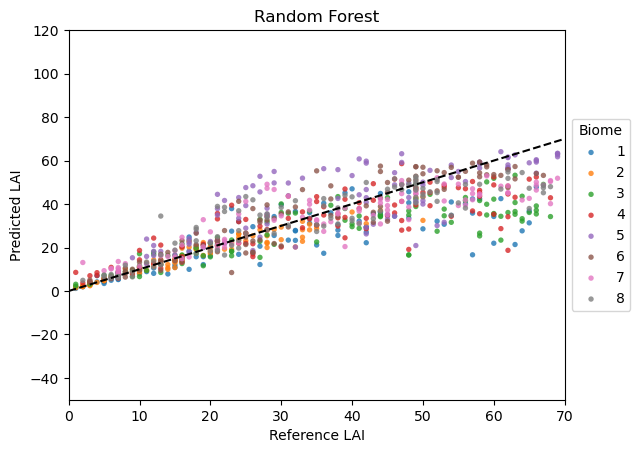

In [43]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    valbiomeDictLAI[i]['y_hat'] = valbiomeDictLAI[i]['rf'].predict(valbiomeDictLAI[i]['X_test'])
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['y_hat'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## Scikit-garden

In [8]:
%%html
<style>
table {float:left}
</style>

To use Scikit-Garden:

| Package       | Version          | Notes                    |
|:--------------|:-----------------|:-------------------------|
| python        | 3.7              |                          |
| numpy         | 1.21  (default)  |                          |
| matplotlib    | 3.5   (default)  |                          |
| pandas        | 1.2   (default)  |                          |
| scikit-learn  | 0.22  (default)  |                          |
| scikit-garden | 0.1.3 (default)  | install with conda-forge |
| jupyterlab    | 3.6   (default)  | install with pip         |

In [9]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

In [10]:
# Creating a Random Forest Quantile Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rfqr'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

In [11]:
print(valbiomeDictLAI[1]['rfqr'])

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
                              max_features=5, max_leaf_nodes=10000,
                              min_samples_leaf=10, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_jobs=-1, oob_score=False, random_state=0,
                              verbose=0, warm_start=False)


In [12]:
# Fitting and predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['rfqr'].set_params(max_features=calbiomeDictLAI[i]['X_train'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])
    valbiomeDictLAI[i]['upper'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['lower'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['mid'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

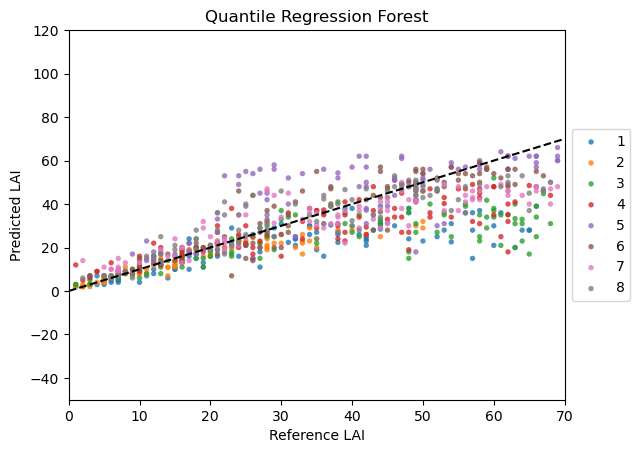

In [45]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['upper'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none', label=str(i))
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['lower'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none', label=str(i))
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Quantile Regression Forest')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Comparing Random Forest and Quantile Forest

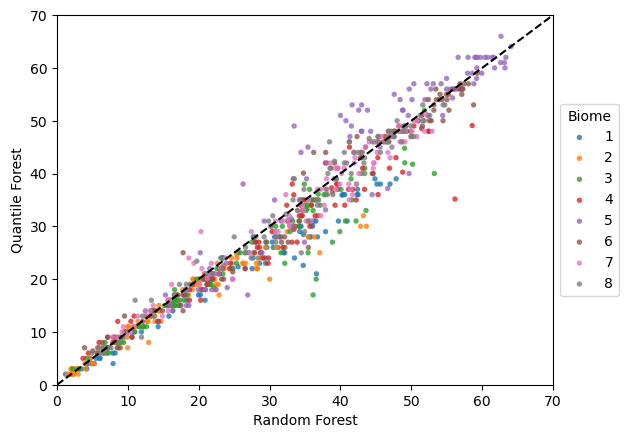

In [20]:
axes=[]
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_hat'], valbiomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
    
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Random Forest")
plt.ylabel("Quantile Forest")
# plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## TensorFlow

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
np.shape(np.array(calbiomeDictLAI[i]['X_train']))

(10000, 5)

In [23]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['tf'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1)])

In [24]:
for i in biomes:
    valbiomeDictLAI[i]['tf'].compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [26]:
for i in biomes:
    callbacks = myCallback()
    valbiomeDictLAI[i]['tf_history'] = valbiomeDictLAI[i]['tf'].fit(calbiomeDictLAI[i]['X_train'].to_numpy(), calbiomeDictLAI[i]['y_train'].to_numpy(), epochs=100, validation_split=0.2, verbose=0, callbacks=[callbacks])
    valbiomeDictLAI[i]['y_tf'] = valbiomeDictLAI[i]['tf'].predict(valbiomeDictLAI[i]['X_test'])

4/4 [==============================] - 0s 3ms/step


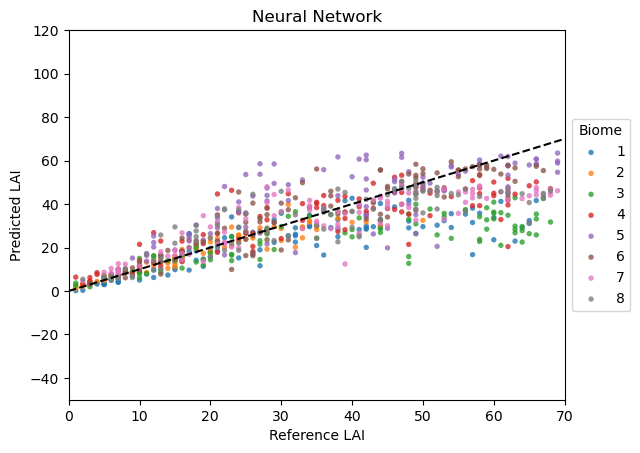

In [27]:
axes = []
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['y_tf'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

In [28]:
valbiomeDictLAI[2]['tf'].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 50)                300       
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,904
Trainable params: 2,901
Non-trainable params: 3
_________________________________________________________________


In [29]:
i = 5
valbiomeDictLAI[i]['tf'].evaluate(valbiomeDictLAI[i]['X_test'],  valbiomeDictLAI[i]['y_test'], verbose=2)

4/4 - 0s - loss: 163.5018 - mean_squared_error: 163.5018 - 159ms/epoch - 40ms/step


[163.50180053710938, 163.50180053710938]

## TensorFlow Probability

In [30]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [31]:
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [32]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['tfp'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(tfpl.IndependentNormal.params_size(1)),
        tfpl.IndependentNormal(event_shape=1)])

In [33]:
for i in biomes:
    valbiomeDictLAI[i]['tfp'].compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

In [34]:
for i in biomes:
    callbacks = myCallback()
    valbiomeDictLAI[i]['tfp'].fit(calbiomeDictLAI[i]['X_train'].to_numpy(), calbiomeDictLAI[i]['y_train'].to_numpy(), epochs=100, validation_split=0.2, verbose=0, callbacks=[callbacks])
    valbiomeDictLAI[i]['y_tfp'] = valbiomeDictLAI[i]['tfp'].predict(valbiomeDictLAI[i]['X_test'])

4/4 [==============================] - 0s 2ms/step


In [35]:
i=1
y_mean = valbiomeDictLAI[i]['tfp'](valbiomeDictLAI[i]['X_test']).mean()
y_sd = valbiomeDictLAI[i]['tfp'](valbiomeDictLAI[i]['X_test']).stddev()

y_hat_lower = y_mean - 2 * y_sd
y_hat_upper = y_mean + 2 * y_sd

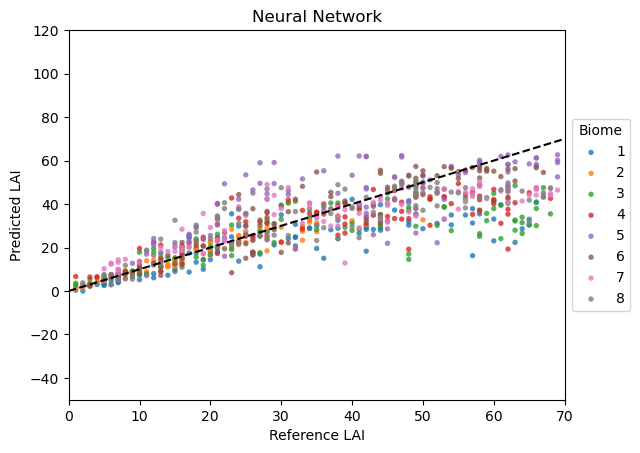

In [36]:
axes = []
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['y_tfp'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

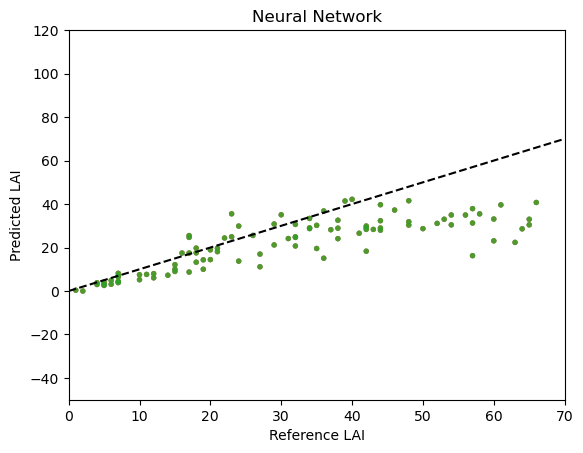

In [37]:
axes = []
# for i in biomes:
i=1
# plt.scatter(valbiomeDictLAI[i]['y_test'], y_hat_lower, alpha=0.8)
plt.scatter(valbiomeDictLAI[i]['y_test'], y_hat_lower, s=15, alpha=0.8, edgecolors='none')
plt.scatter(valbiomeDictLAI[i]['y_test'], y_hat_upper, s=15, alpha=0.8, edgecolors='none')
plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['y_tfp'], s=15, alpha=0.8, edgecolors='none')
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
plt.ylim([-50, 120])
# plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## Create and upload trees

In [ ]:
from sklearn.tree import export_text